# Preparación de entorno

In [88]:
#!pip install qiskit
#!pip install matplotlib
#!pip install qiskit_machine_learning

In [89]:

from qiskit.utils import algorithm_globals

algorithm_globals.random_seed = 123456

In [90]:
import torch

_ = torch.manual_seed(123456)  # suppress output

In [91]:
import numpy as np

num_dim = 1
num_discrete_values = 8
num_qubits = num_dim * int(np.log2(num_discrete_values))

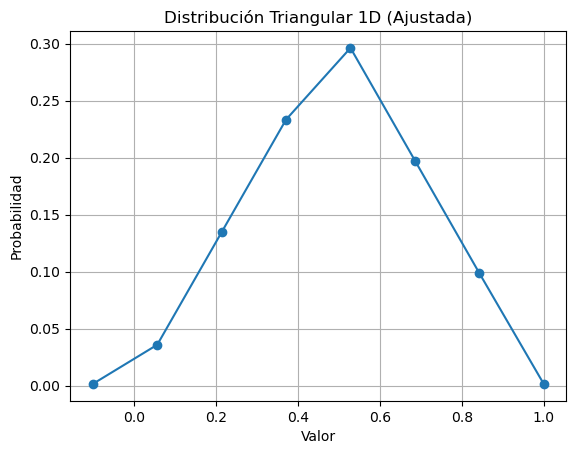

In [92]:
import torch
from qiskit.utils import algorithm_globals
import numpy as np
from scipy.stats import triang

algorithm_globals.random_seed = 123456
_ = torch.manual_seed(123456)  # suppress output

# Fijar la cantidad de dimensiones, la cantidad de valores discretos y calcular la cantidad de qubits requeridos
num_dim = 1  # Cambiamos a 1 dimensión
num_discrete_values = 8  # Esto puede ajustarse según tus necesidades
num_qubits = num_dim * int(np.log2(num_discrete_values))

# Crear una distribución triangular 1D
c = 0.5  # Modifica este valor según tus necesidades para ajustar la forma de la distribución triangular
coords = np.linspace(-0.1, 1, num_discrete_values)
prob_data = triang.pdf(coords, c)

# Ajustar los valores cercanos a 0 a 0.001
prob_data[prob_data < 0.01] = 0.01

# Normalizar para asegurarse de que la suma de las probabilidades sea 1
prob_data = prob_data / np.sum(prob_data)

# Visualizar la distribución triangular 1D
import matplotlib.pyplot as plt

plt.plot(coords, prob_data, marker='o')
plt.xlabel('Valor')
plt.ylabel('Probabilidad')
plt.title('Distribución Triangular 1D (Ajustada)')
plt.grid(True)
plt.show()


In [93]:
from qiskit import QuantumCircuit
from qiskit.circuit.library import EfficientSU2

qc = QuantumCircuit(num_qubits)
qc.h(qc.qubits)

ansatz = EfficientSU2(num_qubits, reps=3)#probar de modificar, para comparar mas resultados
qc.compose(ansatz, inplace=True)

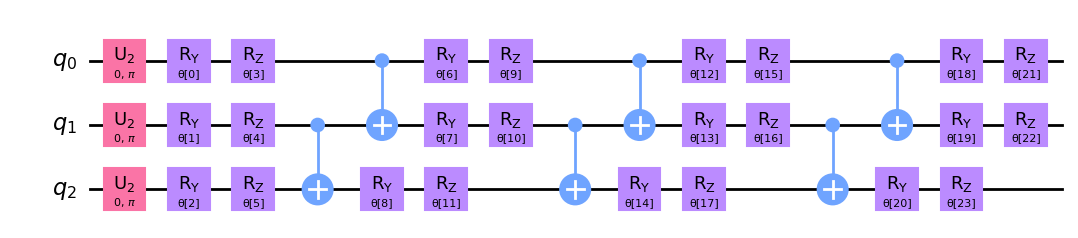

In [94]:
qc.decompose().draw("mpl")

In [95]:
from qiskit.primitives import Sampler

shots = 10000 #
sampler = Sampler(options={"shots": shots, "seed": algorithm_globals.random_seed})

In [96]:
from qiskit_machine_learning.connectors import TorchConnector
from qiskit_machine_learning.neural_networks import SamplerQNN


def create_generator() -> TorchConnector:
    qnn = SamplerQNN(
        circuit=qc,
        sampler=sampler,
        input_params=[],
        weight_params=qc.parameters,
        sparse=False,
    )

    initial_weights = algorithm_globals.random.random(qc.num_parameters)
    return TorchConnector(qnn, initial_weights)

In [97]:
from torch import nn


class Discriminator(nn.Module):
    def __init__(self, input_size):
        super(Discriminator, self).__init__()

        self.linear_input = nn.Linear(input_size, 20)
        self.leaky_relu = nn.LeakyReLU(0.2)
        self.linear20 = nn.Linear(20, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, input: torch.Tensor) -> torch.Tensor:
        x = self.linear_input(input)
        x = self.leaky_relu(x)
        x = self.linear20(x)
        x = self.sigmoid(x)
        return x


In [98]:
generator = create_generator()
discriminator = Discriminator(num_dim)

In [99]:
def adversarial_loss(input, target, w):
    bce_loss = target * torch.log(input) + (1 - target) * torch.log(1 - input)
    weighted_loss = w * bce_loss
    total_loss = -torch.sum(weighted_loss)

    return total_loss


In [100]:
from torch.optim import Adam

lr = 0.01  # learning rate
b1 = 0.7  # first momentum parameter
b2 = 0.999  # second momentum parameter

generator_optimizer = Adam(generator.parameters(), lr=lr, betas=(b1, b2), weight_decay=0.005)
discriminator_optimizer = Adam(
    discriminator.parameters(), lr=lr, betas=(b1, b2), weight_decay=0.005
)

In [101]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

def plot_training_progress():
    # we don't plot if we don't have enough data
    if len(generator_loss_values) < 2:
        return

    clear_output(wait=True)
    fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(18, 13))

    # Generator Loss
    ax1.set_title("Loss")
    ax1.plot(generator_loss_values, label="generator loss", color="royalblue")
    ax1.plot(discriminator_loss_values, label="discriminator loss", color="magenta")
    ax1.legend(loc="best")
    ax1.set_xlabel("Iteration")
    ax1.set_ylabel("Loss")
    ax1.grid()

    # Relative Entropy
    ax2.set_title("Relative entropy")
    ax2.plot(entropy_values)
    ax2.set_xlabel("Iteration")
    ax2.set_ylabel("Relative entropy")
    ax2.grid()

    # ROC Curve
    if len(roc_auc_values) > 0:
        ax4.set_title("ROC Curve")
        ax4.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc_values[-1]:.2f}')
        ax4.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        ax4.set_xlabel('False Positive Rate')
        ax4.set_ylabel('True Positive Rate')
        ax4.legend(loc="lower right")
        ax4.grid()

    with torch.no_grad():
        generated_probabilities = generator(torch.tensor([])).numpy()  # Generate samples using the generator

    # Generate CDF of the generated probabilities
    gen_prob_cdf = np.cumsum(generated_probabilities)
    real_cdf = np.cumsum(prob_data)
    ax5.plot(coords, gen_prob_cdf, label='Generated CDF', color='royalblue')
    ax5.plot(coords, real_cdf, label='True PDF', color='magenta')
    ax5.set_title('Comparison of Generated and True CDF')
    ax5.set_xlabel('Value')
    ax5.set_ylabel('Cumulative Probability')
    ax5.legend()
    ax5.grid()

    # Draw the generated PDF on a 2D plot
    ax6.plot(coords, generated_probabilities, label='Generated PDF', color='royalblue')
    ax6.plot(coords, prob_data, label='True PDF', color='magenta')
    ax6.set_title('Comparison of Generated and True PDF')
    ax6.set_xlabel('Value')
    ax6.set_ylabel('Probability Density')
    ax6.legend()
    ax6.grid(True)

    plt.show()


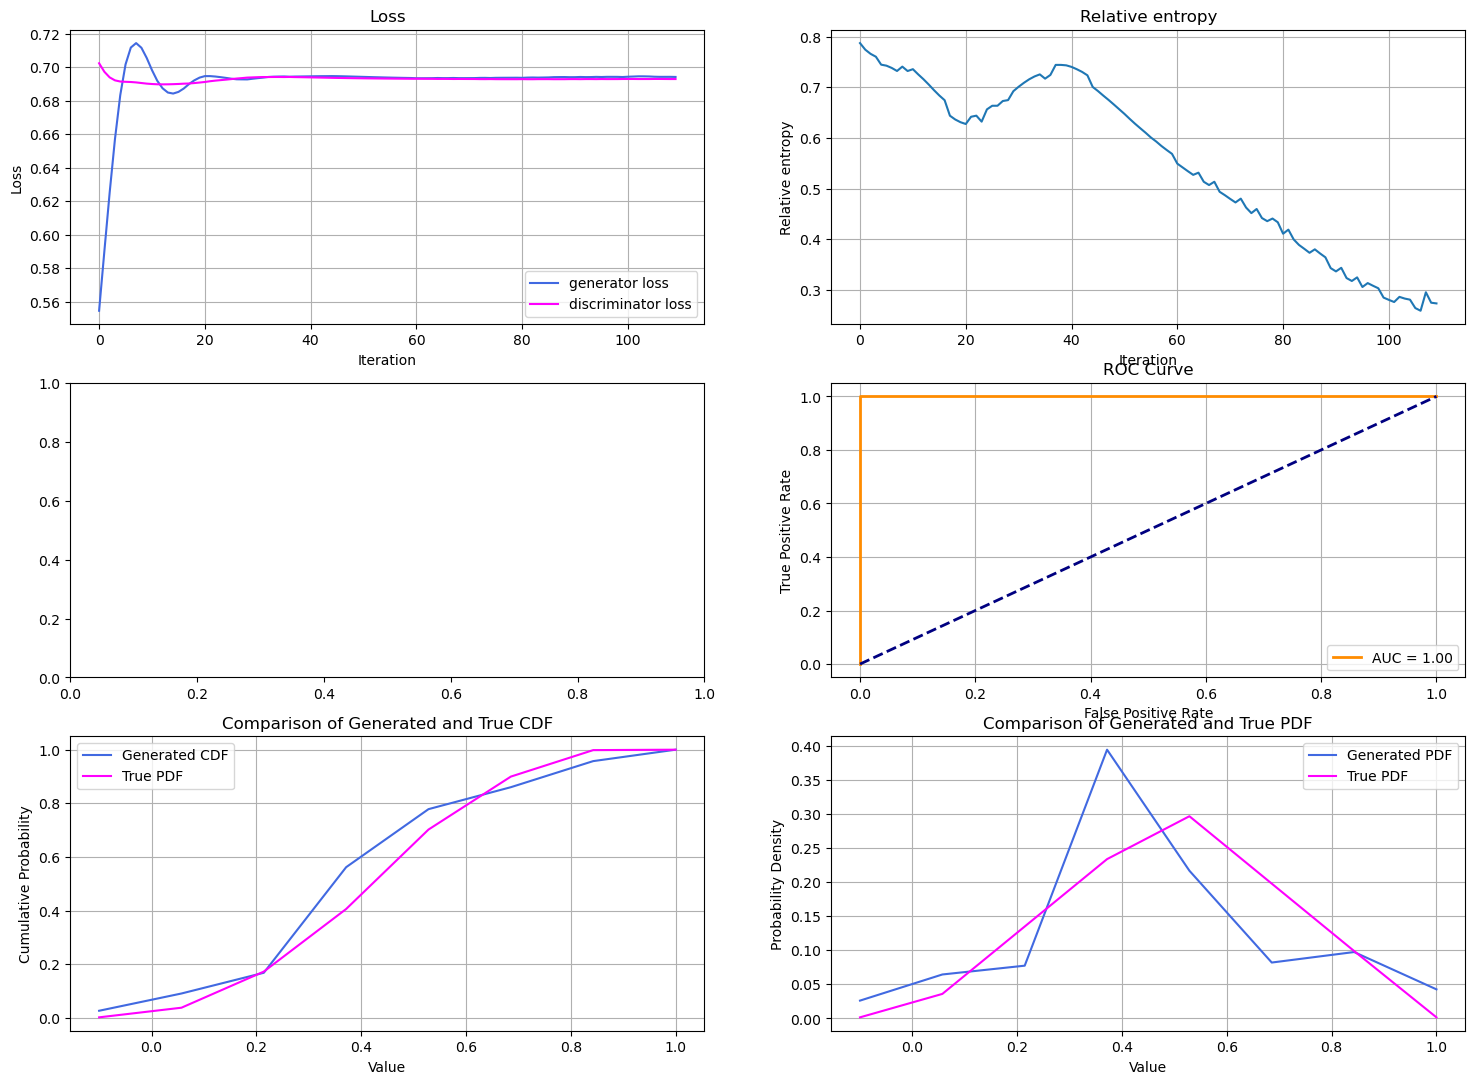

Fit in 196.68 sec


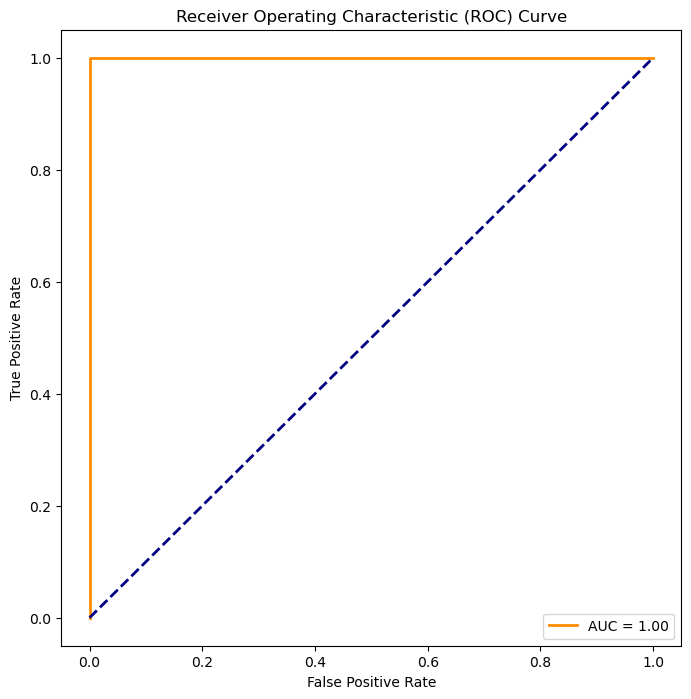

In [102]:
import time
from scipy.stats import multivariate_normal, entropy
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

n_epochs = 110

num_qnn_outputs = num_discrete_values**num_dim

generator_loss_values = []
discriminator_loss_values = []
accuracy_values = []
entropy_values = []
f1_score_values = []
roc_auc_values = []

start = time.time()
for epoch in range(n_epochs):

    valid = torch.ones(num_qnn_outputs, 1, dtype=torch.float)
    fake = torch.zeros(num_qnn_outputs, 1, dtype=torch.float)

    # Configure input
    real_dist = torch.tensor(prob_data, dtype=torch.float).reshape(-1, 1)

    disc_value = discriminator(real_dist)

    # Generate data
    gen_dist = generator(torch.tensor([])).reshape(-1, 1)

    # Train generator
    generator_optimizer.zero_grad()
    generator_loss = adversarial_loss(disc_value, valid, gen_dist)
    generator_loss_values.append(generator_loss.detach().item())
    generator_loss.backward(retain_graph=True)
    generator_optimizer.step()

    # Train Discriminator
    discriminator_optimizer.zero_grad()
    real_loss = adversarial_loss(disc_value, valid, real_dist)
    fake_loss = adversarial_loss(disc_value, fake, gen_dist.detach())
    discriminator_loss = (real_loss + fake_loss) / 2
    discriminator_loss_values.append(discriminator_loss.detach().item())
    discriminator_loss.backward()
    discriminator_optimizer.step()

    # Calculate ROC curve and AUC
    y_true = torch.cat([torch.ones_like(disc_value), torch.zeros_like(gen_dist)])
    y_scores = torch.cat([disc_value, gen_dist.detach()])  # Usa detach() aquí

    fpr, tpr, _ = roc_curve(y_true.detach().numpy(), y_scores.detach().numpy())  # Usa detach() aquí también
    roc_auc = auc(fpr, tpr)
    roc_auc_values.append(roc_auc)

    entropy_value = entropy(gen_dist.detach().squeeze().numpy(), prob_data)
    entropy_values.append(entropy_value)

    plot_training_progress()

elapsed = time.time() - start
print(f"Fit in {elapsed:0.2f} sec")

# Plot ROC curve
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()
